Note: you may need to restart the kernel to use updated packages.


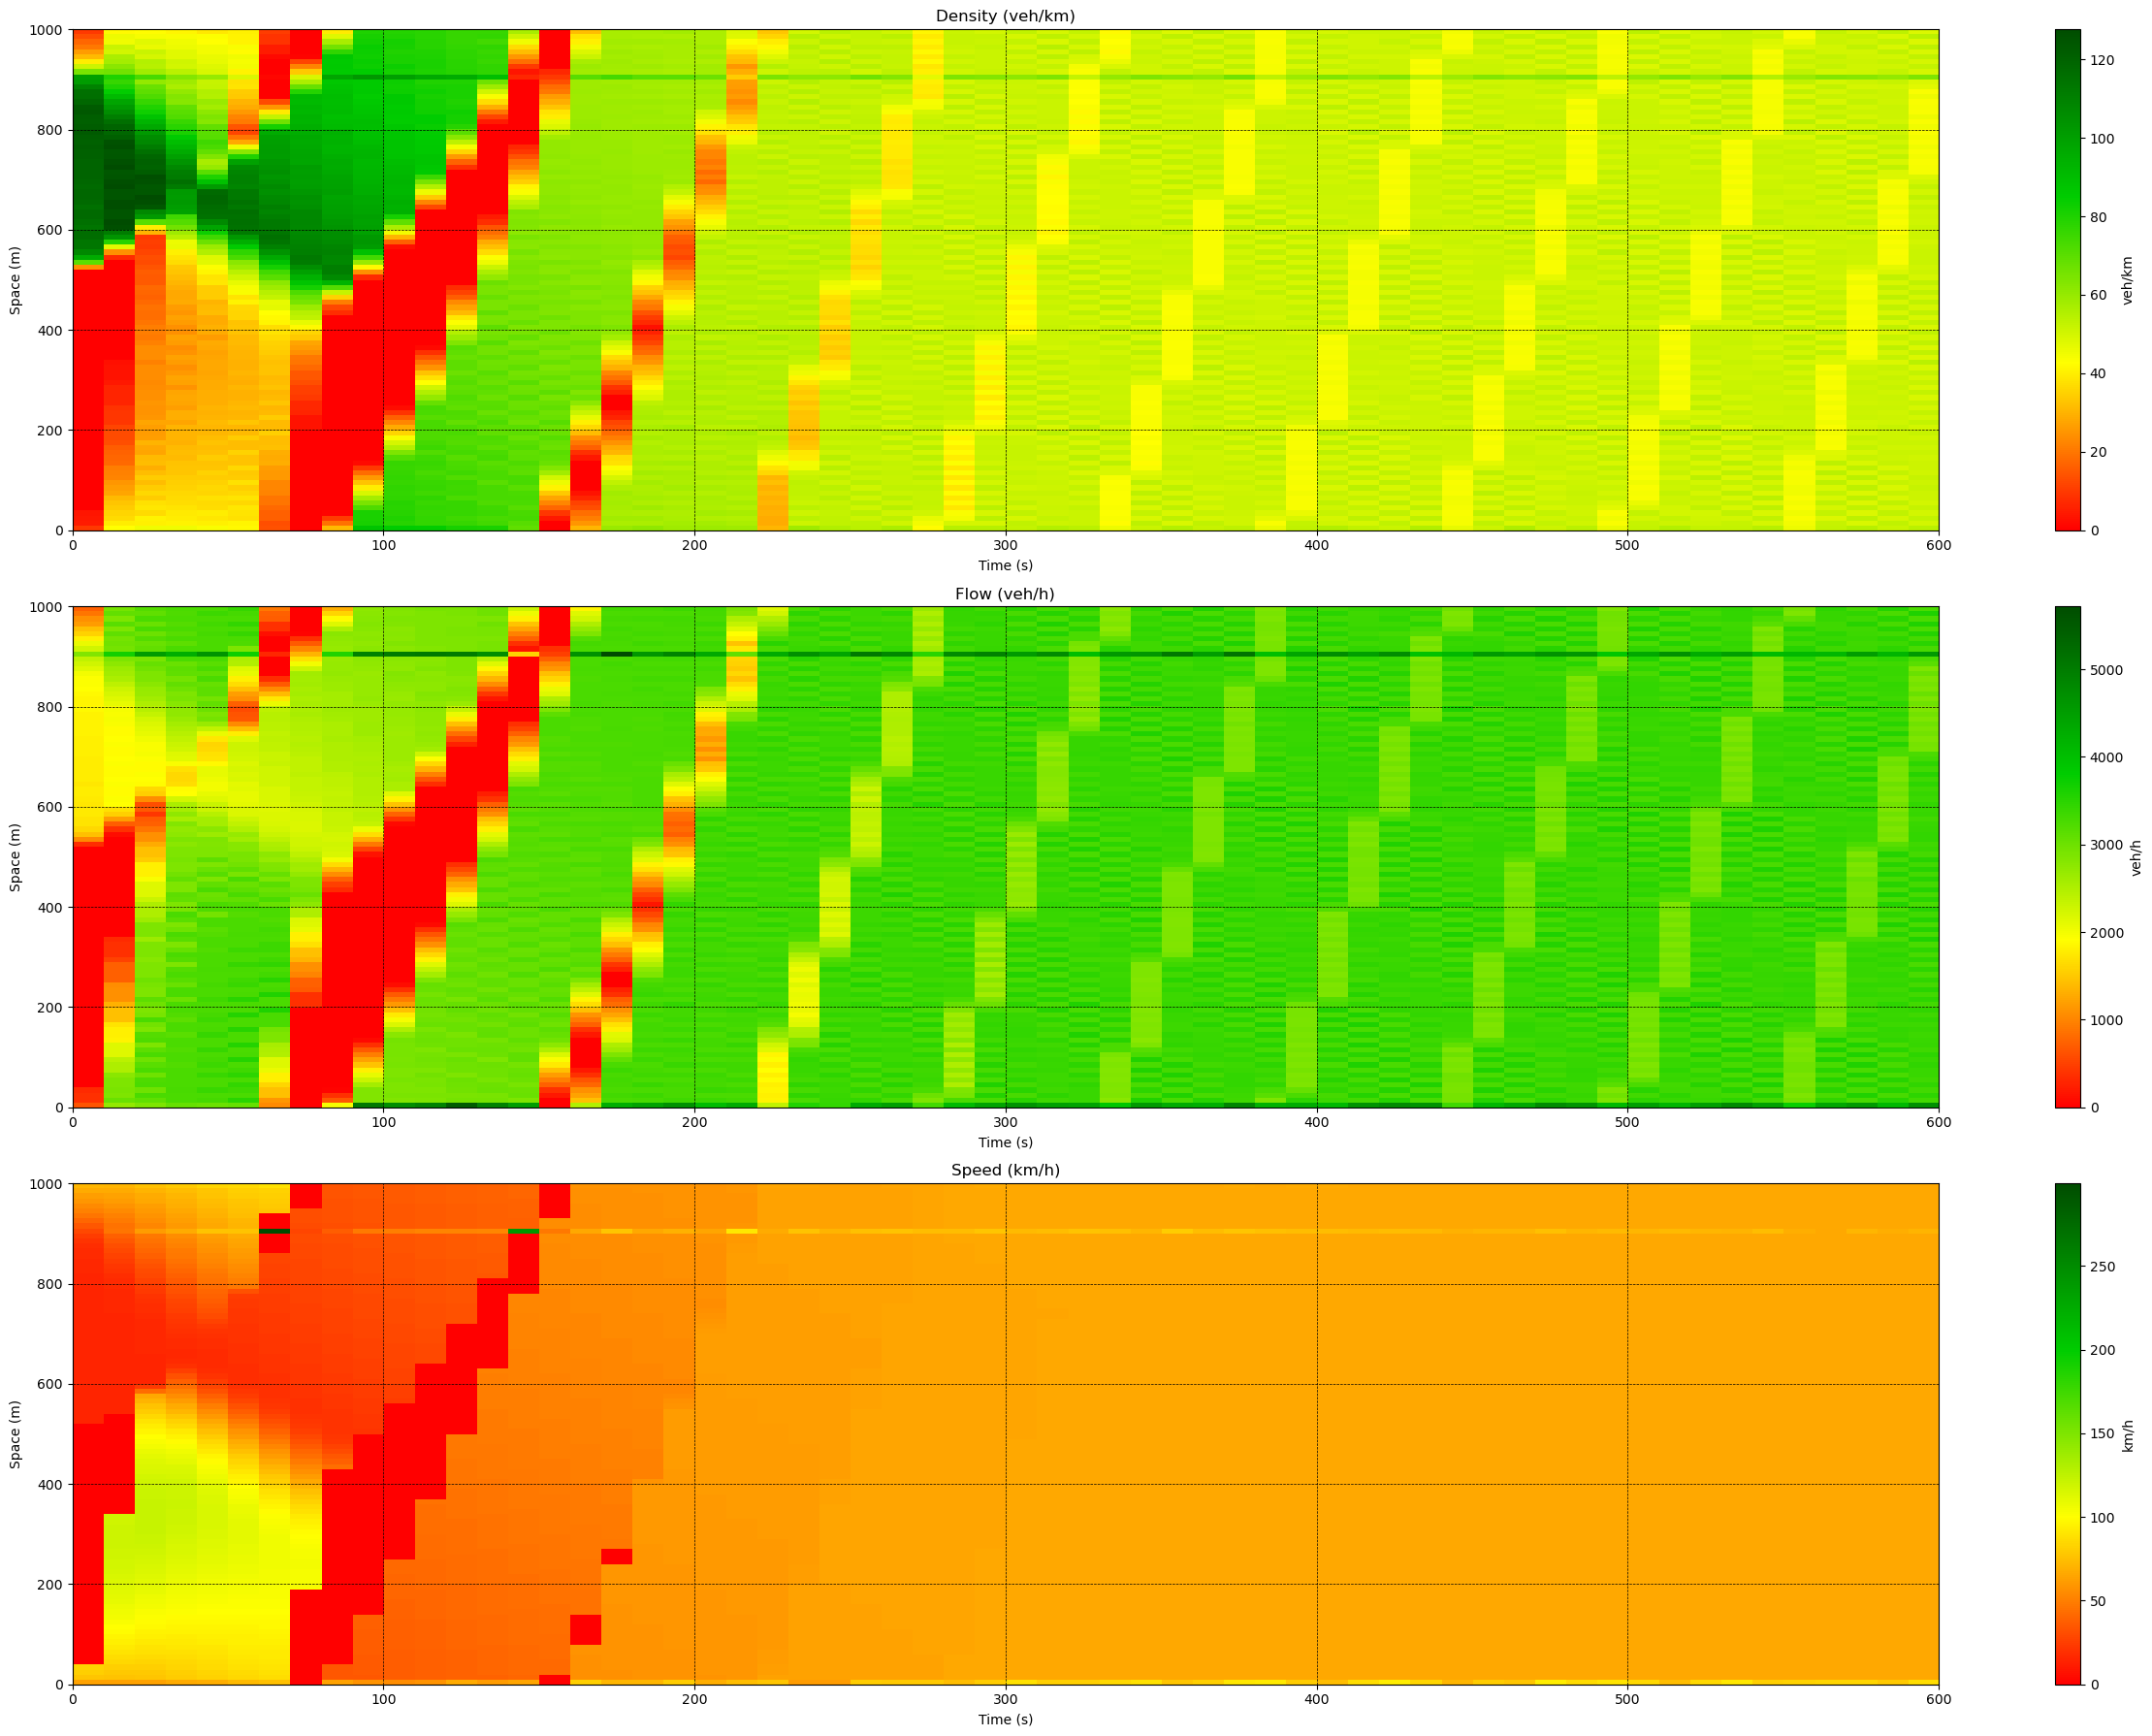

In [1]:
import xml.etree.ElementTree as ET
# Install required packages if not already installed
%pip install numpy matplotlib -q
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
colors = [(1, 0, 0), (1, 1, 0), (0, 0.8, 0), (0, 0.3, 0)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Parse FCD data
tree = ET.parse('output_fcd.xml')
root = tree.getroot()
trajectories = {}
for timestep in root:
    time = float(timestep.attrib['time'])
    for vehicle in timestep.findall('vehicle'):
        veh_id = vehicle.attrib['id']
        edge = vehicle.attrib['lane'].split('_')[0]
        pos = float(vehicle.attrib['pos'])
        if veh_id not in trajectories:
            trajectories[veh_id] = {'times': [], 'edges': [], 'positions': []}
        trajectories[veh_id]['times'].append(time)
        trajectories[veh_id]['edges'].append(edge)
        trajectories[veh_id]['positions'].append(pos)

# Compute unwrapped positions
for veh_id, traj in trajectories.items():
    loop_count = 0
    prev_edge = None
    x_unwrapped = []
    for edge, pos in zip(traj['edges'], traj['positions']):
        if edge == 'a' and prev_edge == 'b':
            loop_count += 1
        if edge == 'a':
            x = loop_count * 1000.76 + pos
        else:  # edge == 'b'
            x = loop_count * 1000.76 + 901.53 + pos
        x_unwrapped.append(x)
        prev_edge = edge
    traj['x_unwrapped'] = x_unwrapped

# Initialize arrays
T = np.zeros((60, 100))
D = np.zeros((60, 100))

# Process trajectories
for traj in trajectories.values():
    for i in range(len(traj['times']) - 1):
        t_start, t_end = traj['times'][i], traj['times'][i+1]
        x_start, x_end = traj['x_unwrapped'][i], traj['x_unwrapped'][i+1]
        n = int(t_start // 10)
        if n >= 60:  # Skip if outside time range
            continue
            
        m_start = int(x_start // 10)
        m_end = int(x_end // 10)
        
        if m_start == m_end:
            m = m_start % 100
            T[n, m] += 0.1
            D[n, m] += max(0, x_end - x_start)  # Ensure non-negative distance
        else:
            x_cross = (m_start + 1) * 10
            # Avoid division by zero
            if abs(x_end - x_start) < 1e-10:
                s = 0.5  # Default to middle of segment if positions are identical
            else:
                s = (x_cross - x_start) / (x_end - x_start)
            t_cross = t_start + s * 0.1
            
            # First segment
            T[n, m_start % 100] += max(0, t_cross - t_start)
            D[n, m_start % 100] += max(0, x_cross - x_start)
            
            # Second segment
            T[n, m_end % 100] += max(0, t_end - t_cross)
            D[n, m_end % 100] += max(0, x_end - x_cross)

# Compute macroscopic quantities
k = T / 100  # veh/m
q = D / 100  # veh/s
v = np.zeros_like(T)  # Initialize with zeros
mask = T > 1e-10  # Use a small threshold to avoid division by zero
v[mask] = D[mask] / T[mask]  # m/s

# Convert units
k_plot = k * 1000  # veh/km
q_plot = q * 3600  # veh/h
v_plot = v * 3.6   # km/h

# Create figure with proper subplots
# Plotting with custom colormap
fig, axes = plt.subplots(3, 1, figsize=(25, 18))
for ax, data, title, unit in zip(axes, [k_plot, q_plot, v_plot], 
                                ['Density', 'Flow', 'Speed'],
                                ['veh/km', 'veh/h', 'km/h']):
    im = ax.imshow(data.T, origin='lower', extent=[0, 600, 0, 1000], 
                   aspect='auto', vmin=0, cmap=green_to_red)  # Remove quotes to use the variable
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(unit)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Space (m)')
    ax.set_title(f'{title} ({unit})')
    ax.set_ylabel('Space (m)')
    ax.set_title(f'{title} ({unit})')
    ax.grid(color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('macroscopic_quantities.png')
plt.show()